## ** PROJECT 1: Automaitc Land Finding**
***

My first Jupyter Notebook. Hopefully it would go well

### Goal:
    1. Apply Canny Transformation, Hough Transformation to extract lane lines in a given frame (or image)
    2. Familiar myself with OpenCV and numpy operation.
    3. Believe that I can be a self-driving engineer :D [ I used to attempt to work on self-driving car projects many times but I always failed because I did not have a mentor nor lacked of knowledge.


### Reflection

### 1. Describe your pipeline. As part of the description, explain how you modified the draw_lines() function.

** My PipeLine/Algorithm **

Global Variables:

* previous left and right lines : to smooth thing out
* smoothness


**For every frame in a video:**
    * Filtering image using Adaptive Equalization and HSV color space to extract white and yellow
    1. Apply Canny Edge and Hough Transform         
    3. Mask Region of Intrest         
    3. For each line segments:
        a. Calculate the slope K and weight (length of the line). Longer the length,more influence on avg. slope
            if (slope > 0): 
                add right_slopes 
                add right points
            if (slope < 0): 
                add  left slopes / left points
    4. Calcualte Median left and right slopes relatively to previous slope
    5. Extrapolate left and right points coordinate to draw the line 
    6. Draw line to original image



### 2. Identify potential shortcomings with your current pipeline

This pipeline could fall when the road lanes are not clear enough. Also, curved lanes could also affect the performance of this pipeline. Hopefully, in the advance lane finding project. I would learn more robust techniques to determine the lanes

In [6]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
from scipy import stats

# Import everything needed to edit/save/watch video clips
import moviepy
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline


---
**Structure of My Code***
1. process_video(): my pipeline is in here
2. Helper methods definition
3. Example using 1 image
4. Example using 1 video
        

## ** Here are my main pipeline**


In [7]:
smooth_level = 0.2     # To slow the change of line during each frame
prev_right_line = np.array([[0,0,0,0]])
prev_left_line = np.array([[0,0,0,0]])

## ** Main Pipeline **
def process_image(frame):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    global prev_right_line
    global prev_left_line
    global smoothness

    im_shape = frame.shape
    xsize = im_shape[0]
    ysize = im_shape[1]

    # Points of polygon
    left_top = (ysize * 0.46, xsize * 0.58)
    left_bottom = (0+ysize*0.01, xsize)
    right_top = (ysize * 0.56, xsize * 0.58)
    right_bottom = (ysize, xsize)  
    vertices = np.array([[left_top, right_top, right_bottom, left_bottom]], dtype=np.int32)   

    # HSV improvement
    hsv = hsv_image(frame)

    # Apply Canny Edge Detection
    canny = edge_detector(hsv, 5, 50, 150)
    
    # Mask a Region Of Interest
    edges = region_of_interest(canny, vertices)

    # Applpy Hough Transform
    h_lines = find_hough_lines(edges,9, 10, 10)
    
    # Extract points and slopes from hough lines
    right_slopes, right_points, left_slopes, left_points = process_hough_lines(h_lines)
    
    # Calculate max min points -- points are sorted in y-axis order
    upper_right = right_points[0]
    lower_right = right_points[-1]
    upper_left = left_points[0]
    lower_left = left_points[-1]
    
    # Calculate average slopes
    right_slope = avg_slope(right_slopes)
    left_slope = avg_slope(left_slopes)
    
    # Determine y = mx +b to draw the line
    upper_y = np.minimum(upper_left[1],upper_right[1]) # to shorten the line
    lower_y = xsize
    
    right_line = get_line(right_slope, right_points, upper_y, lower_y, lower_right)
    left_line  = get_line(left_slope,  left_points,  upper_y, lower_y, lower_left)

    # Smooth the line in each frame
    smoothed_right = eliminate_jittery(right_line, prev_right_line, smooth_level)
    smoothed_left   = eliminate_jittery(left_line, prev_left_line, smooth_level)
    
    prev_right_line = smoothed_right
    prev_left_line =  smoothed_left
    # Draw the lines
    line_image = draw_line_segments(np.copy(frame)*0, [smoothed_right], [255, 0, 0], 11)
    line_image = draw_line_segments(line_image,  [ smoothed_left], [255, 0, 0], 11)
 
    # Blend the lines to original frame
    line_image = region_of_interest(line_image,vertices)
    
    # Just for testing** please ignore
    
    # color_edges = np.dstack((edges, edges, edges))
    # color_edges = np.dstack((canny, canny, canny))
    # color_edges = weighted_img(color_edges, test)
    # est = draw_line_segments(hsv,h_lines,[255,255,0],2)
    # result = weighted_img(frame, line_image)
    result = weighted_img(frame,line_image)
    return result

In [8]:
def get_line(slope, points, upper_y, lower_y, btm_point):
    """
    Determine doninant y-intercept for left and right lines
    """
    if len(points) > 0:
         # Find y-intercept
        avg_point = points[int(len(points)/2)]    
        intercept = avg_point[1] - slope*avg_point[0]
  
        # Calculate X_min
        lower_x = lower_y - intercept
        lower_x = int(lower_x/slope)
        
        # Calculate upper_x
        upper_y = (points[0][1]*3 + upper_y)/4 # Force it to average to each line maximum
        upper_x =  upper_y - intercept
        upper_x = upper_x/slope
        
        line = np.array([[lower_x, int(lower_y),int(upper_x), int(upper_y)]])       
        return line
    
    else:
        return np.array([[0,0,0,0]])

def process_hough_lines(hlines):
    """
    Separate hough lines into left and right.
    Calculate the slope of each lines.
    Get data points of each lines 
    """
     # Initial points    
    coordinate_type = [('x', int),('y', int)]
    right_points = []
    left_points = []
    #Initial slopes
    right_slopes = []
    left_slopes = []
    for line in hlines:
            slope = calculate_slope(line)
            if 0.8 > slope > 0.4:
                w = cal_slope_weight(line)
                right_slopes.append([slope, w])
                for x1, y1, x2,y2 in line:
                    right_points.append((x1, y1))
                    right_points.append((x2, y2))
            elif -0.8 < slope < -0.4:
                w = cal_slope_weight(line)
                left_slopes.append([slope, w])
                for x1, y1, x2,y2 in line:
                    left_points.append((x1, y1))
                    left_points.append((x2, y2))
    # Calculate max, min            
    right_points = np.sort(np.array(right_points, coordinate_type),order='y')
    left_points = np.sort(np.array(left_points, coordinate_type),order='y')  
    return right_slopes, right_points, left_slopes, left_points
    
def calculate_slope(line):
    """
    Calculate a slope of a line segment
    :param line:
    :return: slope value
    """
    for x1, y1, x2, y2 in line:
        slope = (y1 - y2)/(x1 - x2)
        if math.isinf(slope):
            return 0
        else:
            return slope
  
def cal_slope_weight(line):
    for x1,y1, x2, y2 in line:
        distance = math.pow(((x1-x2)**2 + (y1-y2)**2),2)
    return distance   

def eliminate_jittery(line, prev_line, smooth_level):
    """
    Smooth the line coordinate between two frames
    """
    if np.sum(prev_line) != 0: # Initial line = [0,0,0,0] 
        
        # line = smooth_level*line + (1-smoothlevel)*prev_line       
        a = smooth_level*line
        b = (1 - smooth_level)*prev_line
        result = (a + b).astype('int')
        
#         print('Original vs a : ',line, a)
#         print('Previous vs b:', prev_line, b)
#         print('Result       :', result)
#         print('\n')

        return result
        
    else:
        return line

In [9]:
def edge_detector(gray_img, gaussian_kernel_size=1, low_threshold=0, high_threshold=10):
    """
    Return possible edges in an image using Canny Transformation
    :param gray_img:             a grayed image
    :param gaussian_kernel_size: a kernel size for gaussian blur [default is 0]
    :param low_threshold:        default is 0
    :param high_threshold:       default is 10
    :return: edges in an image
    """
    
    # Apply gaussian blur  
    kernel_size = (gaussian_kernel_size, gaussian_kernel_size)
    blurred_image = cv2.GaussianBlur(gray_img, kernel_size, 0)

    # Canny Edge Detection
    canny_edges = cv2.Canny(blurred_image, low_threshold, high_threshold)
    return canny_edges


def find_hough_lines(edge_img, min_votes, min_length, max_gap):
    """
    Return a list of possible Hough Lines in edge_img
    
    :param edge_img:    a canny edge image
    :param min_votes:   a minimum threshold [votes] to be considered a possible line
    :param min_length:  a minimum length to be considered a line
    :param max_gap:     maximum gap between points that have the same line
    :return:            a list of possible lines
    
    Notice : a line in openCV contains : 2 vertices (x1,y1) and (x2,y2)
    """
    
    rho = 1             # perpendicular distance from origin to a line
    theta = np.pi/180   # angle between line and x-axis
    
    # Hough Transform Built-in function of OpenCV. Return a line segments in image
    lines = cv2.HoughLinesP(edge_img, rho, theta, min_votes, np.array([]), min_length, max_gap)

    return lines


def draw_line_segments(source_image, h_lines, color=[255, 0, 0], thickness=2):
    """
    Draw the line segments to the source images.
    """

    line_img = np.copy(source_image)
    for a_line in h_lines:
        for x1, y1, x2, y2 in a_line:
            cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)
    return line_img


def region_of_interest(img, vertices):
    """
    Filter out not-so-important region in the image
    :param source_img:
    :param vertices:    list of vertices to create a polygon
    :return:
    """
    mask = np.zeros_like(img)
    ignore_mask_color = 255
    
     #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    masked_edges = cv2.bitwise_and(img, mask)
    return masked_edges


def adaptive_equalize_image(img, level):
    """
    Equalize an image - Increase contrast for the image
        # http://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html
        
    :param img:    an gray image
    :param level:  clipLevel
    :return: a equalized image
    """
    clahe = cv2.createCLAHE(clipLimit=level)
    result = clahe.apply(img)
    return result

### ** Helper functions **

In [10]:
def gray_image(img):
    """
    Convert color image into gray scale image
    :param img: a color image
    :return: a gray image
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def hsv_image(img):
    """
    Convert BGR to HSV
    green = np.uint8([[[255,236,107]]])
    hsv_green = cv2.cvtColor(green,cv2.COLOR_BGR2HSV)
    print(hsv_green)
    """
    
    # Conver BGR to LAB
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    cl = adaptive_equalize_image(l, 3.0)
    merge = cv2.merge((cl, a, b))
    equalized = cv2.cvtColor(merge, cv2.COLOR_LAB2BGR)
    
    # Convert to HSV image
    hsv = cv2.cvtColor(equalized, cv2.COLOR_BGR2HSV)

    WHITE_MIN = np.array((0,0, 210))
    WHITE_MAX = np.array((140,20,255))
    YELLOW_MIN = np.array((89 ,40, 170))
    YELLOW_MAX= np.array((99, 200, 255))

    white_mask = cv2.inRange(hsv,WHITE_MIN, WHITE_MAX)
    yellow_mask = cv2.inRange(hsv, YELLOW_MIN, YELLOW_MAX)
    mask = cv2.addWeighted(white_mask,1.0,yellow_mask,1.0,0.0)
    hsv = cv2.bitwise_and(img, img, mask= mask)
    return hsv

def avg_slope(slopes):
    """
    calculate avg slope based on the length of the edge (weight). 
    The longer edge, the more it affects the avg slope
    """
    slope = np.transpose(slopes)[0]
    weight = np.transpose(slopes)[1]
    
    mul_sw = np.sum(np.multiply(slope,weight))
    sum_w  = np.sum(weight)
    
    avg_slope = mul_sw/sum_w
    
    return avg_slope

def smooth_slope(new, prev, alpha):
    return alpha*new +(1-alpha)*prev
    
    
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

### ** WORKING WITH 1 SAMPLE IMAGE **

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


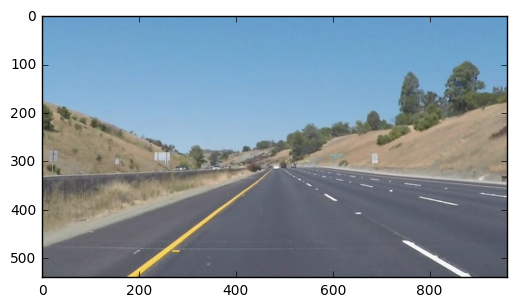

In [14]:
image = mpimg.imread('./test_images/whiteCarLaneSwitch.jpg')

plt.imshow(image)
print('This image is:', type(image), 'with dimensions:', image.shape)

In [15]:
im_shape = image.shape
xsize = im_shape[0]
ysize = im_shape[1]

# Points of polygon
left_top = (ysize * 0.46, xsize * 0.60)
left_bottom = (0+ysize*0.12, xsize)
right_top = (ysize * 0.52, xsize * 0.60)
right_bottom = (ysize - ysize*0.07, xsize)
vertices = np.array([[left_top, right_top, right_bottom, left_bottom]], dtype=np.int32)

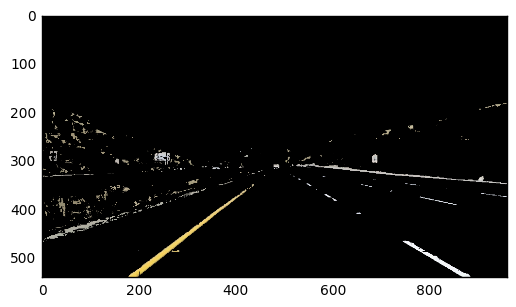

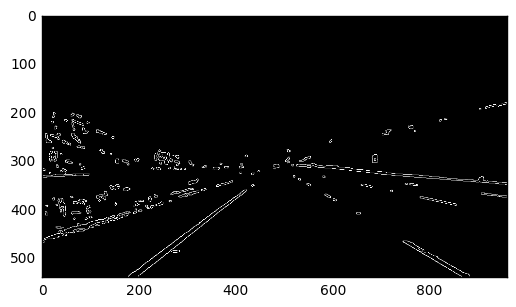

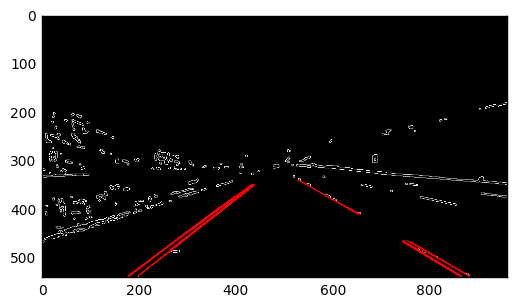

In [16]:
# HSV improvement
hsv = hsv_image(image)

# Apply Canny Edge Detection
canny = edge_detector(hsv, 7, 60, 150)

# Mask a Region Of Interest 
edges = region_of_interest(canny, vertices)

# Hough Transform
h_lines = find_hough_lines(edges, 13, 10, 60)

color_edges = np.dstack((canny, canny, canny)) 
test = draw_line_segments(color_edges,h_lines,[255,0,0],2)
plt.imshow(hsv)
plt.figure()
plt.imshow(color_edges)
plt.figure()
plt.imshow(test)

In [17]:
right_slopes, right_points, left_slopes, left_points = process_hough_lines(h_lines)


upper_right = right_points[0]
lower_right = right_points[-1]
upper_left = left_points[0]
lower_left = left_points[-1]
    
print(upper_left, lower_left)
print(upper_right, lower_right)

(432, 349) (178, 538)
(527, 339) (863, 539)


In [18]:
# Calculate Lines
right_slope = avg_slope(right_slopes)
left_slope = avg_slope(left_slopes)
print(right_slope, left_slope)

0.585100932102 -0.769112240379


In [19]:
# Determine Line
upper_y = np.minimum(upper_left[1],upper_right[1])
print(upper_y)
left_line   = get_line(left_slope,  left_points, upper_y, xsize, lower_left)
right_line  = get_line(right_slope, right_points, upper_y, xsize, lower_right)
print(left_line, right_line)

339
[[178 540 429 346]] [[867 540 524 339]]


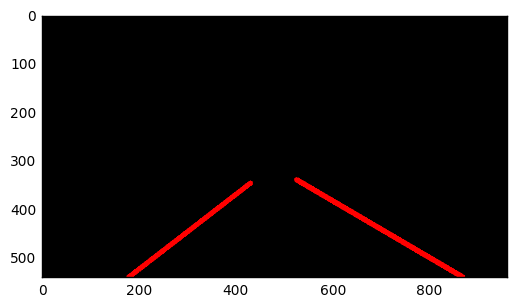

In [20]:
# Draw line
line_image = draw_line_segments(np.copy(image)*0, [left_line], [255,0,0], 10)
line_image = draw_line_segments(line_image,  [right_line], [255, 0, 0], 10)

plt.imshow(line_image)
line_image = region_of_interest(line_image,vertices)
result = weighted_img(image, line_image)

Original Image: 
Canny Edge and Hough Transform:
Result:


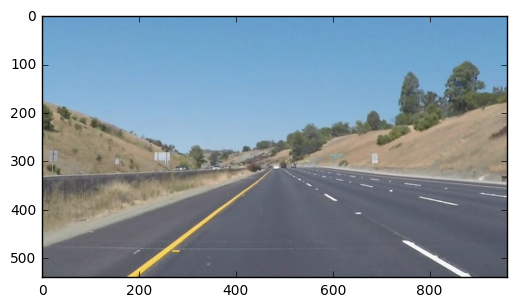

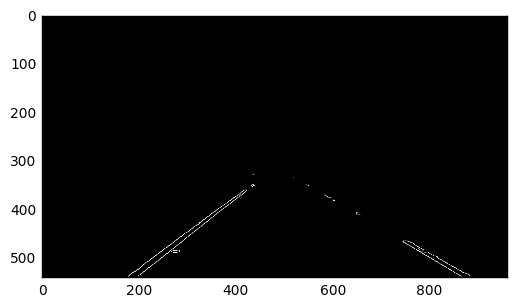

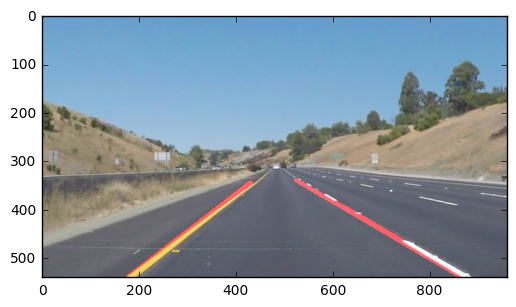

In [21]:
# Display all line

plt.figure(1)
print("Original Image: ")
plt.imshow(image)

plt.figure(2)
print("Canny Edge and Hough Transform:")
plt.imshow(edges, cmap='gray')

plt.figure(3)
print("Result:")
plt.imshow(result)

### Now Working on The Video
    

In [24]:
white_output = 'output.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)   # NOTE: this function expects color images!!
white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████▉| 221/222 [00:14<00:00, 15.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

